In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

plt.style.use('bmh')
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

In [2]:
import myModule.simulation as myModule
import myModule.halo as halo
import myModule.gas as gas
import myModule.chandrasekhar as chandra
import myModule.accretion as accretion

In [3]:
## Units
# Mass:     1e6 Solar Masses
# Distance: Parsecs
# Time:     1e6 Years (Myr)

# Parameters
G = 4490.0            # Gravitational Constant
n_steps = 1000        # Number of steps in the simulation

# Initial conditions
t_init = 0                    # Initial time of the simulation
t_final = 300                 # Final time of the simulation
m_init = 2                    # Initial mass of the black hole
r_init = np.array([2e3,0,0])  # Initial position of the black hole
v_init = np.array([0,200,0])  # Initial velocity of the black hole

# Halo component
v_h = 230.160
q = 0.9
r_c = 0

# Gas component (Miyamoto-Nagai)
a = 6.5e3
b = 0.26e3
M = 1e5               # Total mass of the galaxy

# Dynamical Friction (Chandrasekhar)

logLambda = 1.0       # Coulomb logarithm 
sigma = 76.65         # Velocity dispersion

# Mass accretion
v_s = 9.198           # Speed of sound in the gas (from the interstellar cloud of the solar system)
tau = 50              # Salpeter Timescale
epsilon = 1.000       # Efficiency

In [4]:
def m_dot(r,v,m):
    if m < M:
        return min(epsilon*4*np.pi*(M-m)*gas.density(r)*G*G*m*m*(v_s*v_s+np.sum(v*v))**-1.5,m/tau)
    return 0

In [5]:
mySim = myModule.simulation()

haloGravity = myModule.interaction('Halo Gravity', halo.acceleration,v_h=v_h,q=q,r_c=r_c)
gasGravity = myModule.interaction('Gas Gravity', gas.acceleration,G=G,a=a,b=b,M=M)
gasFriction = myModule.interaction('Gas Dynamical Friction', chandra.acceleration,G=G,logLambda=logLambda,rho=gas.density,sigma=sigma)
haloFriction = myModule.interaction('Halo Dynamical Friction', chandra.acceleration,G=G,logLambda=logLambda,rho=halo.density,sigma=sigma)
massAccretion = myModule.interaction('Mass Accretion', accretion.acceleration,m_dot=m_dot)

mySim.interactions.append(haloGravity)
mySim.interactions.append(gasGravity)
mySim.interactions.append(gasFriction)
mySim.interactions.append(haloFriction)
mySim.interactions.append(massAccretion)

mySim.updateDerivatives()

In [6]:
t = np.linspace(t_init,t_final,n_steps)
s_init = np.concatenate((r_init, v_init, m_init*np.ones(1)))
mySim.integrate(t_init, t_final, n_steps, s_init)

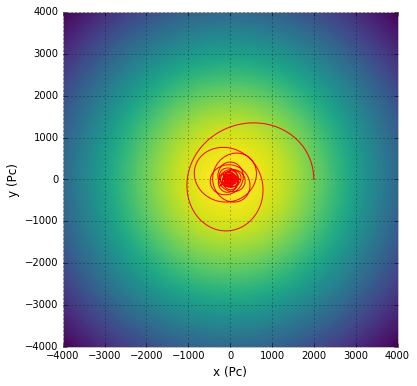

In [7]:
def density(x,y,z):
    R2 = x*x+y*y+z*z
    rho = M*b*b*(a*R2+(a+3*(z*z+b*b)**.5)*(a+(z*z+b*b)**.5)**2)
    rho /=4*np.pi*((R2+(a+(z*z+b*b)**.5)**2)**2.5)*((z*z+b*b)**1.5)
    return rho

x = np.linspace(-4e3,4e3,1e2)
y = np.linspace(-4e3,4e3,1e2)
X,Y = np.meshgrid(x,y)
rho = density(X,Y,0)

plt.plot(mySim.path[:,0],mySim.path[:,1],'r',lw=1)
plt.contourf(X,Y,rho, levels=np.linspace(np.min(rho),np.max(rho),100), cmap='viridis')
plt.xlabel('x (Pc)')
plt.ylabel('y (Pc)')

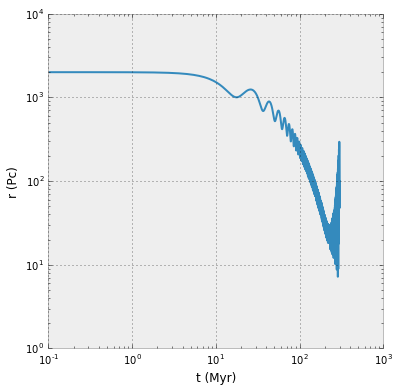

In [8]:
plt.plot(t,np.sum(mySim.path[:,:3]**2,axis=1)**.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('t (Myr)')
plt.ylabel('r (Pc)')

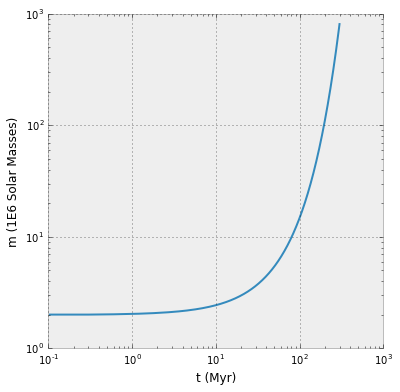

In [9]:
plt.plot(t,mySim.path[:,6])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('t (Myr)')
plt.ylabel('m (1E6 Solar Masses)')

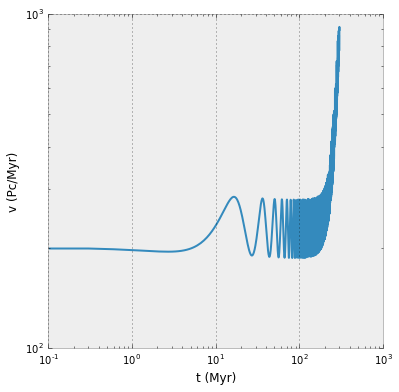

In [10]:
plt.plot(t,np.sum(mySim.path[:,3:7]**2,axis=1)**.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('t (Myr)')
plt.ylabel('v (Pc/Myr)')